In [1]:
import glob
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_log_error, r2_score

In [ ]:
# note to self -- params as chosen by cross validation
# RF params -- sqrt, 100 estimators
# xgb params -- 100 estimators, start at mean, subsample all, lambda 0.5, alpha 1

In [2]:
train = pd.read_parquet("final_train_2.parquet").sample(n = 1500000, random_state = 55)

In [3]:
neighbor_cols = [f'neighbor_{n}' for n in range(25)]
input_cols = ['imputed_epa_pm25_value', 'imputed_hum', 
              'imputed_temperature', 'wind_x','wind_y', 
              'ndvi', 'elevation'] + neighbor_cols

## Random Forest

In [4]:
rf = RandomForestRegressor(n_estimators = 100, max_features='sqrt', random_state = 23)

In [6]:
%%time
rf.fit(train[input_cols], train['2_5um'])

CPU times: user 10min 56s, sys: 4.86 s, total: 11min 1s
Wall time: 11min 1s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=23, verbose=0, warm_start=False)

In [8]:
test = pd.read_parquet("final_test_2.parquet").sample(600000, random_state = 1234)
test['pred'] = rf.predict(test[input_cols])

In [9]:
mean_squared_error(test['2_5um'], test['pred'])**0.5

5.753493448568002

In [12]:
r2_score(test['2_5um'], test['pred'])

0.7950376467285989

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

(0, 200)

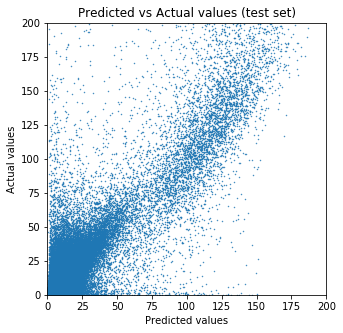

In [15]:
f, a = plt.subplots(figsize=(5,5))
a.scatter(test['pred'],test['2_5um'], s = 0.2)
a.set_title("Predicted vs Actual values (test set)")
a.set_ylabel("Actual values")
a.set_xlabel("Predicted values")
a.set_ylim(0,200)
a.set_xlim(0,200)


In [18]:
from joblib import dump, load
dump(rf, 'RF_final.joblib') 

['RF_final.joblib']

In [31]:
feature_importance = pd.DataFrame({'Feature':input_cols, 
                                   'Importance':rf.feature_importances_, 
                                   'Rank':1 + np.argsort(rf.feature_importances_)[::-1]})

In [42]:
feature_importance

,Feature,Importance,Rank
0,imputed_epa_pm25_value,0.557002,1
1,imputed_hum,0.053915,7
2,imputed_temperature,0.049091,2
3,wind_x,0.037032,6
4,wind_y,0.036315,3
5,ndvi,0.052464,4
6,elevation,0.053955,5
7,neighbor_0,0.005040,22
8,neighbor_1,0.006678,18
9,neighbor_2,0.002850,17


In [43]:
feature_importance.to_csv("final_RF_feature_importance.csv", index = False)

In [34]:
import gc
del rf
gc.collect()

6091

## xgboost

In [35]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                          n_estimators = 100,
                          reg_lambda = 0.5,
                          reg_alpha = 1,
                          base_score = train['2_5um'].mean(),
                          random_state = 23)

In [37]:
%%time
import warnings
warnings.filterwarnings("ignore")
xg_reg.fit(train[input_cols], train['2_5um'])

CPU times: user 2min 24s, sys: 779 ms, total: 2min 25s
Wall time: 2min 25s


XGBRegressor(base_score=5.928776273333332, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=23, reg_alpha=1,
             reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [39]:
test['pred_xgb'] = xg_reg.predict(test[input_cols])

In [40]:
mean_squared_error(test['2_5um'], test['pred_xgb'])**0.5, r2_score(test['2_5um'], test['pred_xgb'])

(7.73006673072799, 0.6300207744056023)

(0, 200)

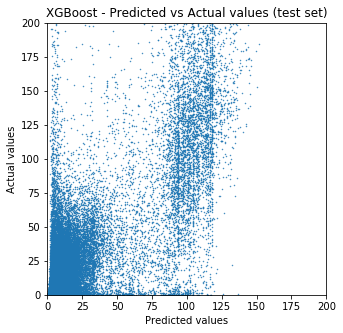

In [41]:
f, a = plt.subplots(figsize=(5,5))
a.scatter(test['pred_xgb'],test['2_5um'], s = 0.2)
a.set_title("XGBoost - Predicted vs Actual values (test set)")
a.set_ylabel("Actual values")
a.set_xlabel("Predicted values")
a.set_ylim(0,200)
a.set_xlim(0,200)